# Lecture 9: Fitting Part Deux (the Sequel)

In this module, we will work with real science data! We will also talk about comparing fits we are also going to implement some wrapper functions which allow us to fit data sets over a given range so we can do full fits with sensible initial guesses. 

We will also discuss reading in data from a file (real science data!) and we'll talk about comparing fits to see which one better fits the dataset. 

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import math

from scipy import optimize

## Reading Data from Disk

In [11]:
#These data have been taken from:
#A search for enhanced very high energy gamma-ray emission from the March 2013 Crab Nebula flare
#E. Aliu, S. Archambault, T. Aune, et al. (2014). ApJL, 781:1
#adsabs.harvard.edu/abs/2014ApJ...781L..11A

with open("../data/lecture9/fermi_data.dat") as f:
    while True:
        line = f.readline().strip()
        print(line)
        if line == '':
            # either end of file or just a blank line.....
            # we'll assume EOF
            break

#Fermi-LAT energy points
#E (GeV) F(erg/cm^2/s) error(erg/cm^2/s)
0.1197284 2.782675e-10 4.320226e-12
0.175736 1.371493e-10 3.437277e-12
0.2579454 6.840274e-11 3.201041e-12
0.3786163 3.922656e-11 3.036997e-12
0.5557299 3.79908e-11 3.317519e-12
0.8156986 3.746278e-11 3.640678e-12
1.197284 2.859329e-11 3.89845e-12
1.757371 3.660324e-11 4.20265e-12
2.579468 4.329536e-11 4.663271e-12
3.786146 4.741375e-11 5.152214e-12
5.5573 6.087261e-11 5.770672e-12
8.156999 6.221362e-11 6.120325e-12
12.9863 8.188062e-11 5.886341e-12
23.09326 9.476316e-11 7.09109e-12
41.06628 9.320332e-11 8.569925e-12
73.02731 8.268462e-11 1.073483e-11
129.863 8.038287e-11 1.435097e-11
225.9676 7.980947e-11 1.934809e-11



We need to parse this information. Firstly, there are two header rows which need to be eliminated. 

Secondly, we need to parse this information into a variable that we can manipulate. 

Line 0 is a comment.
Line 1 is a comment.
['0.1197284', '2.782675e-10', '4.320226e-12']
['0.175736', '1.371493e-10', '3.437277e-12']
['0.2579454', '6.840274e-11', '3.201041e-12']
['0.3786163', '3.922656e-11', '3.036997e-12']
['0.5557299', '3.79908e-11', '3.317519e-12']
['0.8156986', '3.746278e-11', '3.640678e-12']
['1.197284', '2.859329e-11', '3.89845e-12']
['1.757371', '3.660324e-11', '4.20265e-12']
['2.579468', '4.329536e-11', '4.663271e-12']
['3.786146', '4.741375e-11', '5.152214e-12']
['5.5573', '6.087261e-11', '5.770672e-12']
['8.156999', '6.221362e-11', '6.120325e-12']
['12.9863', '8.188062e-11', '5.886341e-12']
['23.09326', '9.476316e-11', '7.09109e-12']
['41.06628', '9.320332e-11', '8.569925e-12']
['73.02731', '8.268462e-11', '1.073483e-11']
['129.863', '8.038287e-11', '1.435097e-11']
['225.9676', '7.980947e-11', '1.934809e-11']


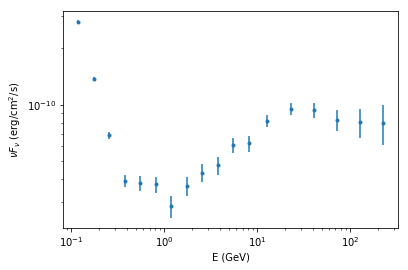

In [12]:
energy_bin = []
nuFnu = []
nuFnu_error = []

with open("../data/lecture9/fermi_data.dat") as f:
    line_index = 0
    while True:
        line = f.readline().strip()
        #print(line)
        if line == '':
            # either end of file or just a blank line.....
            # we'll assume EOF
            break
        elif line[0] == '#':
            print("Line {0:d} is a comment.".format(line_index))
        else:
            values = line.split(" ") #the delimeter between fields here is the space ' '. This can be basically any delimiter in practice.
            print(values)
            #Looks like we have a nice set of numbers to work with.
            energy_bin += [float(values[0])]
            nuFnu += [float(values[1])]
            nuFnu_error += [float(values[2])]
        
        line_index+=1 

energy_bin = np.array(energy_bin, dtype=float)
nuFnu = np.array(nuFnu, dtype=float)
nuFnu_error = np.array(nuFnu_error, dtype=float)
plt.errorbar(energy_bin, nuFnu, yerr=nuFnu_error, fmt='.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("E (GeV)")
plt.ylabel(r"$ \nu F_\nu $ (erg/cm$^2$/s)")

#Now, let's talk about what the units of the spectrum are. 

In [13]:
#the numpy.loadtxt() function is incredibly handy for loading a table of data.

fermi_data = np.loadtxt("../data/lecture9/fermi_data.dat",skiprows=2,unpack=1)

print(fermi_data)
print(fermi_data.shape)

veritas_baseline = np.loadtxt("../data/lecture9/veritas_baseline.dat",skiprows=2,unpack=1)
veritas_flare = np.loadtxt("../data/lecture9/veritas_flate.dat",skiprows=2,unpack=1)


[[  1.19728400e-01   1.75736000e-01   2.57945400e-01   3.78616300e-01
    5.55729900e-01   8.15698600e-01   1.19728400e+00   1.75737100e+00
    2.57946800e+00   3.78614600e+00   5.55730000e+00   8.15699900e+00
    1.29863000e+01   2.30932600e+01   4.10662800e+01   7.30273100e+01
    1.29863000e+02   2.25967600e+02]
 [  2.78267500e-10   1.37149300e-10   6.84027400e-11   3.92265600e-11
    3.79908000e-11   3.74627800e-11   2.85932900e-11   3.66032400e-11
    4.32953600e-11   4.74137500e-11   6.08726100e-11   6.22136200e-11
    8.18806200e-11   9.47631600e-11   9.32033200e-11   8.26846200e-11
    8.03828700e-11   7.98094700e-11]
 [  4.32022600e-12   3.43727700e-12   3.20104100e-12   3.03699700e-12
    3.31751900e-12   3.64067800e-12   3.89845000e-12   4.20265000e-12
    4.66327100e-12   5.15221400e-12   5.77067200e-12   6.12032500e-12
    5.88634100e-12   7.09109000e-12   8.56992500e-12   1.07348300e-11
    1.43509700e-11   1.93480900e-11]]
(3, 18)


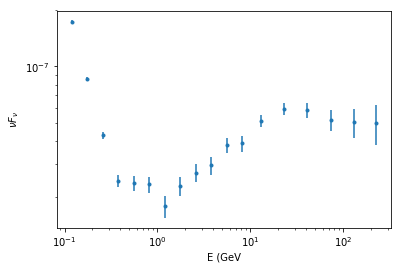

In [14]:
def gev_to_erg(gev):
    return 0.00160217662*gev


for data in [fermi_data]:
    E, nuFnu, nueF = data
    plt.errorbar(E, nuFnu/gev_to_erg(1), nueF / gev_to_erg(1),fmt='.')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('E (GeV')
plt.ylabel(r"$\nu F_\nu$")

[  8.52409851e-07   3.83450641e+00] [  2.01044443e-09   1.30340000e-02]


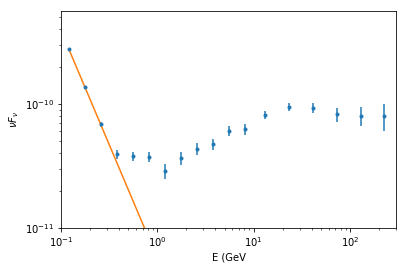

In [15]:
def power_law2(x, *params):
    F0, gamma = params
    
    #return F0 * (gamma+1.) * pow(x, gamma) / (300.**(gamma + 1) - (0.1**(gamma + 1)))
    return (F0 * (gamma-1.) * pow(x, -gamma) / (pow(0.1, 1.-gamma)))
            
F = nuFnu
eF = nuFnu_error
c,cov = optimize.curve_fit(power_law2, E, nuFnu / gev_to_erg(1.) / E / E, p0=[6e-7, 3.0], sigma=eF)
print(c, np.sqrt(np.diag(cov)))

plt.errorbar(E,F,eF,fmt='.')
plt.yscale("log")
plt.xscale("log")
plt.plot(E, (E*E*power_law2(E,*c) * gev_to_erg(1.)))
plt.xlim(0.1,300.)
plt.ylim(1.e-11,)
plt.xlabel('E (GeV')
plt.ylabel(r"$\nu F_\nu$")

It looks like our fit converged, but looking at the plot you can see that it only really fits the first few data points. This is because their error bars are so much smaller than the other ones, they hold a lot more weight. 

You can imagine a situation where if the errors were all equal, this might not be the case (We saw some of this last week.)

The results here are not quite consistent with the results from the paper; they're actually a bit high.

This is because the flux is actually the sum of two different components; syncrhotron emission and inverse Compton emission. Later, you will do the exercise of fitting both compoents simultaneously in an attempt to match public results. 

Earlier we loaded two more datasets. Let's now plot all the data at the same time and see what the full energy spectrum looks like. 

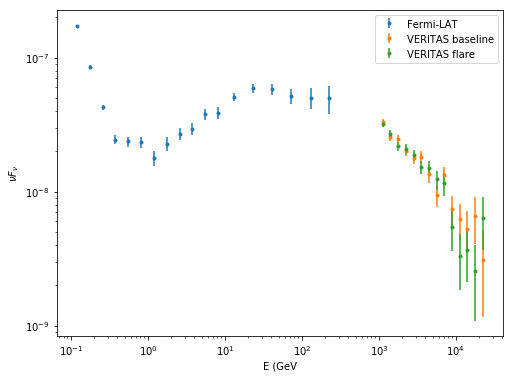

In [16]:
plt.figure(figsize=[8,6])
for data,dataset_name in zip([fermi_data, veritas_baseline, veritas_flare], 
                             ['Fermi-LAT', 'VERITAS baseline', 'VERITAS flare']):
    E, nuFnu, nueF = data
    plt.errorbar(E, nuFnu/gev_to_erg(1), nueF / gev_to_erg(1),fmt='.', label=dataset_name)
    
plt.yscale("log")
plt.xscale("log")
plt.xlabel('E (GeV')
plt.ylabel(r"$\nu F_\nu$")
plt.legend()
plt.show()

#OK, so, it looks like two of the datasets are actually overlapping with energy. 
#If you read the paper, you will see that some of the data were taken while the Crab Nebula was flaring in the MeV range

#We haven't included those data in this notebook (but look at the figure in the paper).
#We should fit these data and see if they are different or not -- if they are, it might mean new physics.

In [17]:
import scipy.stats

def calc_chisquare(meas, sigma, fit):
    '''
    returns a chiquared value given measurements, errors, and the predicted value.
    '''
    
    diff = pow(meas-fit, 2.)
    test_statistic = (diff / pow(sigma,2.)).sum()
    
    return test_statistic


def power_law(x, *params):
    
    norm, index = params
    
    return norm * pow(x / 1000., index)


## Fitting data over a range

One way to fit data over a given range would be to slice the arrays containing the X- and Y- data and fit only the sliced data. This can be a bit clunky, however, it would be nice to write a function that looks something like 


    def fit(f, x, y, guess=None, fit_range=[]):
        ...  

We can start by implementing a wrapper for curve_fit().

## More complicated model fitting

Looking at the dataset from before, we see that there are two components. We want to fit for both of them. We already know the model for the synchrotron radiation (a power law) but we should not try to characterize the Inverse Compton peak. 

In the literature, the high-energy side of the IC peak is generally charcterized with a curved power law: 

$$ \frac{dN}{dE} = f_0 \left(\frac{E}{E_0}\right)^{-\alpha + \beta \log(E/E_0)}$$. 

where now we have three parameters, and we've introduced at term called the 'normalisation energy'. It is an important value, but we do not fit to it; we usually fix it to a value. We will fit it to 1 TeV. 

In [18]:
def curved_power_law(x, *params):
    '''
    This function assumes that the x-axis has units of GeV.
    We are fixing the normalisation at 1 TeV.
    '''
    f0, alpha, beta = params
    
    return f0 * pow(x/1000., -alpha + beta * np.log10(x / 1000.))

## Extracting data from papers.

Often, you will want to use someone else's publsihed data but the (e.g.) spectral points are not readily avaialbel online. This is particularly true for older papers with archival measurements. We can use programs like WebPlotDigitizer to do some of the data extraction for us! http://arohatgi.info/WebPlotDigitizer/

Try it on the data in this paper: https://arxiv.org/pdf/1703.01307.pdf (note the corresponding author!)

There are three different measurmeents of the same object using three different observing modes -- NOM, RHV, and UVF -- you will need to extract 9 different sets of data -- the points, and then the upper and lower error bars. The data have been fitted with power laws -- can you reproduce the results in the paper? 

In-class exercise: Extract the spectral data and reproduce the plot in Figure 6. You should find and plot the archival measurements, but you do not need to plot the error bands (this requires a bit of work, since it involves error propagation). This work will count as part of a homework assignment. 